Challenge_1: Aerial Cactus-AML

In [387]:
# Imports
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
import numpy as np

# Phase 1: Loading the data, analyzing it, doing feature engineering and creating the Loader

In [388]:
# Cactus Dataset model
class CactusDataset(Dataset):
    def __init__(self,train='./data/train/train',labels='./data/train.csv',transform=None,target_transform=None):
        if labels is None:
            self.df=None
        else:
            self.df=pd.read_csv(labels)
        self.imgPath=train
        self.transform=transform
        self.target_transform=target_transform
    def __len__(self):
        # here you just need to return a single integer number as the length of your dataset, in your 
        #  case, number of images in your train folder or lines in csv file
        if self.df is not None:
            return len(self.df)
        else:
            return len(os.listdir(self.imgPath))
    def __getitem__(self, idx):
        # if we already have the labels we can use them to find the nth element otherwise we use the folder order. This is used for
        # example when we have only a partial number of labels compared to the number of images or when we don't have them at all
        img_path = os.path.join(self.imgPath, self.df['id'][idx] if self.df is not None else os.listdir(self.imgPath)[idx])
        image = Image.open(img_path).convert('RGB')
        if self.df is not None:
            label = self.df['has_cactus'][idx]
        else:
            label = None
        # we perform transformations if they are not None and the labels are not None
        if self.transform:
            image = self.transform(image)
        if self.target_transform is not None and label is not None:
            label = self.target_transform(label)
        return image, label
    
    # this function is used to get the distribution of the labels in the dataset
    def label_distribution(self):
        if self.df is not None:
            return self.df['has_cactus'].value_counts(ascending=True).values
        else:
            return np.array([0,0])
        
class ConcatTransformDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.transforms = transforms

    def __getitem__(self, index):
        dataset_idx, sample_idx = self._get_dataset_index(index)
        image, label = self.datasets[dataset_idx][sample_idx]
        return image, label

    def __len__(self):
        return sum(len(dataset) for dataset in self.datasets)

    def _get_dataset_index(self, index):
        for i, dataset in enumerate(self.datasets):
            if index < len(dataset):
                return i, index
            index -= len(dataset)
        raise IndexError('Index out of range')

In [389]:
# load data for displaying
dataset=CactusDataset()
# take the first sample from train_dataloader
train_features, train_labels = dataset[10000]
image_np = np.array(train_features)
print("Image shape: "+str(image_np.shape))
print("Image python class"+str(type(train_features)))
print("Label: "+str(train_labels))

Image shape: (32, 32, 3)
Image python class<class 'PIL.Image.Image'>
Label: 0


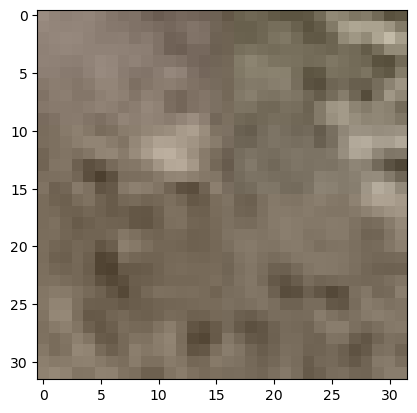

In [390]:
# show the image
plt.imshow(image_np)

[ 4364 13136]


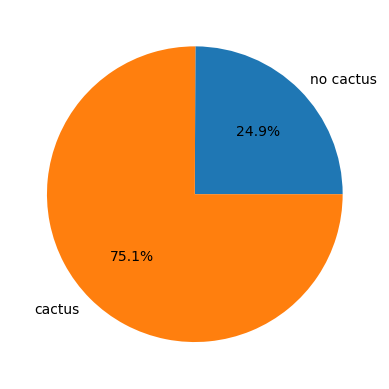

In [391]:
label_distribution = dataset.label_distribution() # they are sorted in ascending order
print(label_distribution)
fig, ax = plt.subplots()
ax.pie(label_distribution, labels=['no cactus','cactus'], autopct='%1.1f%%')
plt.show()

In [392]:
print("Number of train values: "+str(dataset.__len__()))

Number of train values: 17500


Image python class<class 'torch.Tensor'>
Image shape: torch.Size([3, 128, 128])


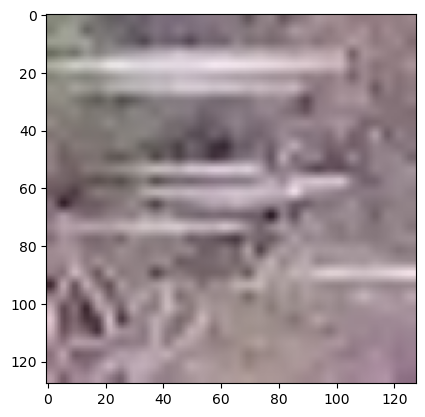

In [393]:
transform_dataset = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

dataset = CactusDataset(transform=transform_dataset)
image, label = dataset[0]
print("Image python class"+str(type(image)))
print("Image shape: "+str(image.shape))
# show the image
plt.imshow(image.permute(1,2,0))

In [394]:
dataloader=DataLoader(dataset,batch_size=32,shuffle=True)

In [395]:
for i, (images, labels) in enumerate(dataloader):
    print("Batch number: "+str(i))
    print("Batch images shape: "+str(images.shape))
    print("Batch labels shape: "+str(labels.shape))
    break

Batch number: 0
Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels shape: torch.Size([32])


Number of no cactus images: 4364
Number of train values: 4364
Number of cactus images: 17500
Number of no cactus images: 8728


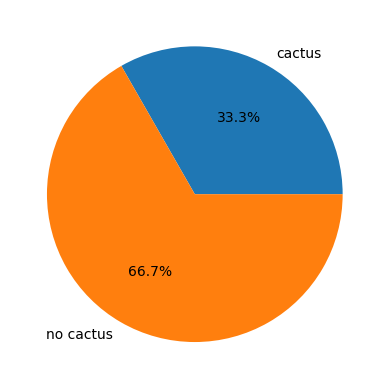

In [396]:
# TODO we might want to add a network with the already labeled points to classify some image from the test set in order to arrive to a more balanced dataset
# --------- DATA AUGMENTATION ---------
# we want to place some data augmentation with the no cactus images
transform_augmented = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor()
])

dataset_augmented = CactusDataset(transform=transform_augmented)
# remove the has_cactus=1 images before augmentation and keep also the first row (id,has_cactus)
dataset_augmented.df=dataset.df[dataset.df['has_cactus']==0]
dataset_augmented.df=dataset_augmented.df.reset_index(drop=True)

# print the size of the dataset
print("Number of no cactus images: "+str(dataset_augmented.__len__()))
# create the data loader with both the augmented and the original dataset
dataset_merged=ConcatTransformDataset([dataset,dataset_augmented])

# print the size of the new dataset
print("Number of train values: "+str(dataset_augmented.__len__()))
# redo statistics of the pie on the concatDataset
label_distribution_augmented=dataset_augmented.label_distribution()
label_distribution_concat=np.add(label_distribution,label_distribution_augmented)
# print the new numbers
print("Number of cactus images: "+str(label_distribution_concat[1]))
print("Number of no cactus images: "+str(label_distribution_concat[0]))
# plot the new pie
fig, ax = plt.subplots()
ax.pie(label_distribution_concat, labels=['cactus','no cactus'], autopct='%1.1f%%')
plt.show()

In [397]:
# --------- CREATING THE DATA LOADER AND TRAIN/VAL SPLIT ---------
train_size = int(0.8 * len(dataset_merged))
print("Train size: " + str(train_size))
test_size = len(dataset_merged) - train_size
print("Test size: " + str(test_size))
train_dataset, val_dataset = torch.utils.data.random_split(dataset_merged, [train_size, test_size])

# Retrieve the lengths of the datasets
print("Merged dataset length: " + str(len(dataset_merged)))
print("Train dataset length: " + str(len(train_dataset)))
print("Validation dataset length: " + str(len(val_dataset)))
print("Augmented dataset length: " + str(len(dataset_augmented)))

# Create DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Print an item from the train_dataloader (torch tensor)
for i, (images, labels) in enumerate(train_dataloader):
    print("Batch number: " + str(i))
    print("Batch images shape: " + str(images.shape))
    break


Train size: 17491
Test size: 4373
Merged dataset length: 21864
Train dataset length: 17491
Validation dataset length: 4373
Augmented dataset length: 4364
Batch number: 0
Batch images shape: torch.Size([32, 3, 128, 128])


 # Phase 2: defining the model